In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import librosa
import sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import pandas
import seaborn as sns
import csv
import itertools
import pandas as pd
from scipy.special import comb
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif, mutual_info_regression, SelectPercentile, GenericUnivariateSelect
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [2]:
DATADIR = ""
CATEGORIES = ["DATASET1/Segmented_Laugh", "DATASET1/Segmented_NonLaugh1"]

# Defining Functions

In [3]:
def createcombinations(n):
    elements = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
    a = list(itertools.combinations(elements, n))
    a = np.asarray(a).astype(int)
    return a

In [4]:
def create_training_data(t_frame, t_shift, n_mfccs, component, training_data, n_features):
    count=0
    error_count = 0
    laugh_counter = 0
    nonlaugh_counter = 0
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category) 
        class_num = CATEGORIES.index(category)
        for aud in os.listdir(path):
            if aud == '.DS_Store':
                continue
            
            aud_array , sr = librosa.load(os.path.join(path,aud), sr=None)
            count+=1

            mfccs = []
            
            try:
                mfcc = (librosa.feature.mfcc(aud_array, sr=sr,  n_mfcc=20,  win_length = int(sr*t_frame), hop_length = int(sr*t_shift))) 
                
                mfcc_temp = mfcc[component,:]
                mean_mfccs = np.mean(np.asarray(mfcc_temp),axis = 1)
                #std_mfccs = np.std(np.asarray(mfcc_temp), axis = 1)
                #var_mfccs = np.var(np.asarray(mfcc_temp), axis = 1)
                
                #mfcc_delta = librosa.feature.delta(mfcc_temp)
                #mfcc_delta_var = np.var(np.asarray(mfcc_delta),axis = 1)
                #mfcc_delta_std = np.std(np.asarray(mfcc_delta),axis = 1)
                
                #mfcc_delta2 = librosa.feature.delta(mfcc_delta)
                #mfcc_delta2_mean = np.mean(np.asarray(mfcc_delta2),axis = 1)
                #mfcc_delta2_var = np.var(np.asarray(mfcc_delta2),axis = 1)
                #mfcc_delta2_std = np.std(np.asarray(mfcc_delta2),axis = 1)
                
                
                mfccs.append(mean_mfccs)
                #mfccs.append(std_mfccs)
                #mfccs.append(mfcc_delta_std)
                #mfccs.append(mfcc_delta2_std)
                
                mfccs = np.asarray(mfccs).reshape(n_mfccs*n_features,1)
                
                training_data.append([mfccs.reshape(-1,1), class_num])
                if category == 'DATASET1/Segmented_Laugh':
                    laugh_counter +=1
                else:
                    nonlaugh_counter += 1
                    if nonlaugh_counter >= laugh_counter:
                        break

            except ValueError:
                pass
            
    return laugh_counter, nonlaugh_counter
    

In [5]:
def createaccuracy(file, n_iterations):
    with open('SVM_Mean.csv', 'r') as f:
        file_lines = f.readlines()

    keymap =  pd.DataFrame([string.split(',') for string in file_lines])
    keymap_np = keymap.to_numpy()

    row_list = [["MFCCs", "Mean_Accuracy", "STD_Accuracy"]]
    for i in range(int(comb(20, file , exact=False))):
        accuracy = []
        for j in range(n_iterations):
            accuracy.append(float(keymap_np[n_iterations*i+1+j,5]))
    
        mean_accuracy = np.mean(np.asarray(accuracy))
        std_accuracy = np.std(np.asarray(accuracy))
    
        row_list.append([keymap_np[n_iterations*i+1,0], mean_accuracy, std_accuracy])

    with open('SVM_Mean_Accuracy.csv', 'w', newline='') as newfile:
        writer = csv.writer(newfile)
        writer.writerows(row_list)
    

# Main Loop

In [6]:
def scaling(X,n_mfcc):
    for i in range(n_mfcc):
        X[:,i] = X[:,i]/(np.mean(X[:,i]))
        

    #X[:,1] = np.square(X[:,1])
        
    return X

In [64]:
#Choose these parameters. Calculates results for combinations of mfccs, from 0-9, taken n_mfcc at a time.
n_iterations = 10
for n_mfcc in range(1,2):
    print("n_mfcc = ", n_mfcc)
    
    n_features = 1
    component = createcombinations(n_mfcc)
    t_frame = 0.025
    t_shift = 0.01
    
    row_list = [["MFCCs", "Actual(0)Predicted(0)", "Actual(0)Predicted(1)", "Actual(1)Predicted(0)", "Actual(1)Predicted(1)","Accuracy","(0) f1", "(0) Precision", "(0) Recall","(1) f1", "(1) Precision", "(1) Recall", "Number of Entries (0)", "Number of Entries (1)",  ]]
    
    for components in component:
        #print("For Components ", components)
        #print("Loading Data....")
        training_data = []
        laugh, nonlaugh = create_training_data(t_frame, t_shift, n_mfcc, components, training_data, n_features)
        print(laugh, nonlaugh)
    
        #print("PreProcessing Data....")
        random.shuffle(training_data) 
        X = []
        Y = []
        for features, label in training_data:
            X.append(features)
            Y.append(label)
        
        X = np.array(X).reshape(-1,n_mfcc*n_features)
        Y = np.array(Y)
        X = scaling(X,n_mfcc)
        #if np.int(components) == 0:
        #    X = np.log(X)
        #X = X/100
        
        #print("Running Classifier....")
        for i in range(n_iterations):
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1) 
            classifier = svm.SVC(kernel='linear')
            classifier.fit(X_train,y_train)
            y_pred = classifier.predict(X_test)
    
            cmatrix = confusion_matrix(y_test,y_pred, labels=[0,1])
            report = classification_report(y_test, y_pred, output_dict=True)
            df = pandas.DataFrame(report).transpose()
            creport = df.to_numpy()
    
            row_list.append([str(components) + 'Delta2', cmatrix[0,0], cmatrix[0,1], cmatrix[1,0], cmatrix[1,1], creport[2,1], creport[0,0], creport[0,1], creport[0,2], creport[1,0], creport[1,1], creport[1,2],  creport[0,3], creport[1,3]]) 
        #print(" ")
        #break
    #Writing your results into a file
    with open('SVM_Mean.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(row_list)

    createaccuracy(n_mfcc, n_iterations)    


n_mfcc =  1
779 779
779 779


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


779 779
779 779
779 779
779 779


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Pre

779 779
779 779
779 779
779 779
779 779
779 779
779 779
779 779
779 779
779 779
779 779
779 779
779 779
779 779


In [10]:
with open('SVM_Mean' + str(n_mfcc) + '.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(row_list)

createaccuracy(n_mfcc, n_iterations) 

In [144]:
fit = test.fit(np.abs(X), Y)

In [145]:
np.set_printoptions(precision=3)
print(fit.scores_)

GenericUnivariateSelect(mode=array([0, 0, 0, ..., 1, 1, 1]), param=1e-05,
                        score_func=array([[0.611, 1.234, 1.493, ..., 2.582, 5.062, 8.457],
       [1.582, 0.381, 2.744, ..., 0.242, 1.374, 3.721],
       [0.897, 0.678, 3.666, ..., 0.402, 0.528, 7.805],
       ...,
       [1.446, 1.188, 1.822, ..., 0.096, 0.774, 2.85 ],
       [1.493, 0.861, 0.382, ..., 0.335, 2.527, 1.338],
       [1.626, 0.989, 0.8  , ..., 1.504, 0.737, 1.291]], dtype=float32))


In [141]:
np.set_printoptions(precision=3)
print(fit.scores_)

SelectPercentile(percentile=array([0, 0, 0, ..., 1, 1, 1]),
                 score_func=array([[0.611, 1.234, 1.493, ..., 2.582, 5.062, 8.457],
       [1.582, 0.381, 2.744, ..., 0.242, 1.374, 3.721],
       [0.897, 0.678, 3.666, ..., 0.402, 0.528, 7.805],
       ...,
       [1.446, 1.188, 1.822, ..., 0.096, 0.774, 2.85 ],
       [1.493, 0.861, 0.382, ..., 0.335, 2.527, 1.338],
       [1.626, 0.989, 0.8  , ..., 1.504, 0.737, 1.291]], dtype=float32))


In [18]:
features = fit.transform(X)
print(features[0:5,:])

[[  1.882   1.502  28.519   0.989  -6.35 ]
 [  1.07   -0.491 -19.33   -0.614  20.659]
 [  1.409   1.844   6.042   0.127   4.868]
 [  1.711   0.966  51.878  -1.204  -1.296]
 [  0.415   4.41  -37.065   3.797   1.433]]


In [19]:
X[1:10,12]

array([20.659,  4.868, -1.296,  1.433, -0.625, -9.749, -3.326,  6.963,
        1.001], dtype=float32)

In [113]:
mean = []
meanlaugh = []
meannon = []
std = []
for i in range(13):
    mean.append(np.mean(X[:,i]))
    meanlaugh.append(np.mean(X[np.where(Y==0),i]))
    meannon.append(np.mean(X[np.where(Y==1),i]))
    std.append(np.std(X[:,i]))
    print('Mean = ', mean[i], 'Laugh =', meanlaugh[i], 'Non=', meannon[i])

Mean =  1.0 Laugh = 1.1095622 Non= 0.89043796
Mean =  1.0 Laugh = 0.9544908 Non= 1.0455092
Mean =  1.0 Laugh = 1.0430954 Non= 0.95690465
Mean =  0.99999994 Laugh = 0.9307801 Non= 1.0692197
Mean =  1.0000001 Laugh = 1.0266362 Non= 0.97336394
Mean =  1.0 Laugh = 0.9852591 Non= 1.0147411
Mean =  1.0 Laugh = 1.0446537 Non= 0.9553464
Mean =  1.0 Laugh = 1.0241225 Non= 0.9758774
Mean =  0.99999994 Laugh = 1.0199288 Non= 0.98007107
Mean =  1.0 Laugh = 1.0342109 Non= 0.96578914
Mean =  1.0 Laugh = 1.0697546 Non= 0.93024546
Mean =  1.0 Laugh = 1.0491366 Non= 0.9508634
Mean =  1.0000001 Laugh = 1.1115739 Non= 0.8884263


In [202]:
Y = X

In [221]:
X = Y

array([], dtype=float32)

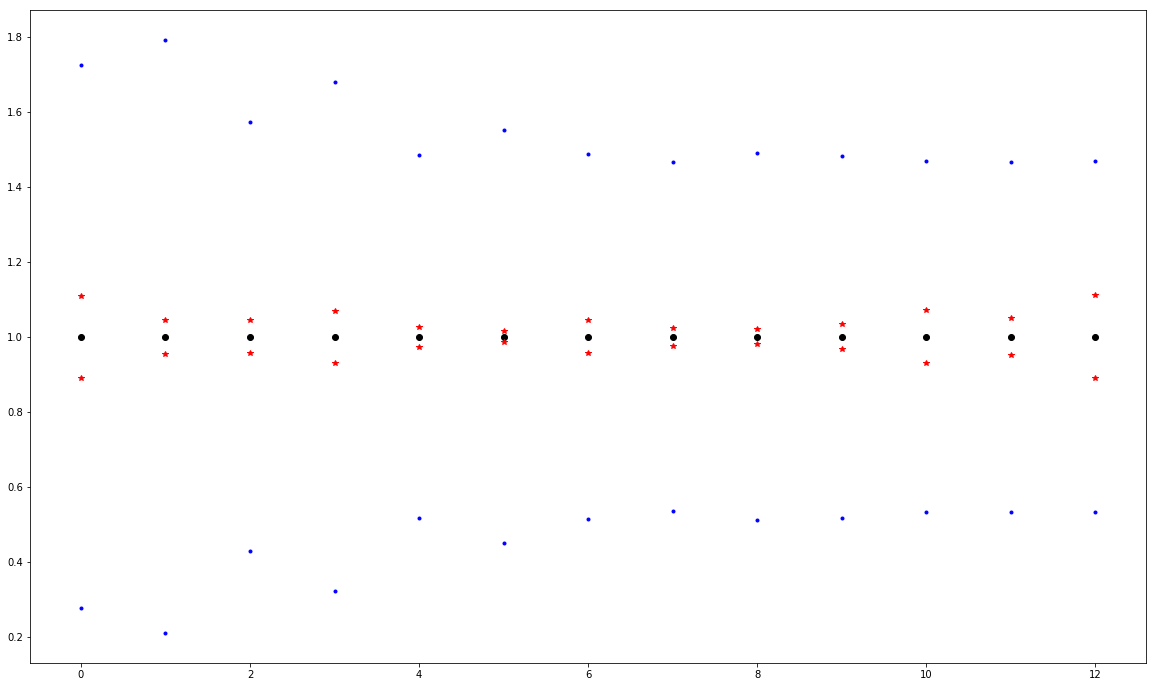

In [116]:
plt.figure(figsize=(20, 12))
plt.plot(mean,'ko')
plt.plot(meanlaugh,'r*')
plt.plot(meannon,'r*')
plt.plot(np.array(mean)+np.array(std),'b.')
plt.plot(np.array(mean)-np.array(std),'b.')

In [42]:
np.array(mean) + np.array(std)

array([ 1.573,  1.435,  2.996,  1.46 ,  1.851,  2.985,  1.487, 33.068,
        2.619,  4.605,  2.709,  3.272,  7.681], dtype=float32)

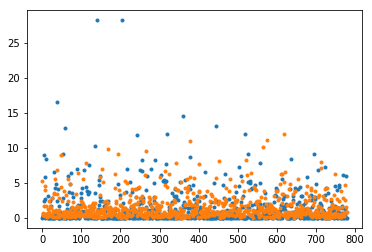

In [117]:
plt.plot(np.square(X[np.where(Y==1),0]).T,'.')
plt.plot(np.square(X[np.where(Y==0),0]).T,'.')

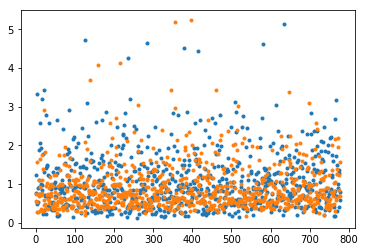

In [120]:
plt.plot((X[np.where(Y==1),3]).T,'.')
plt.plot((X[np.where(Y==0),3]).T,'.')

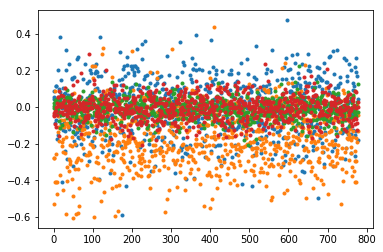

In [188]:
plt.plot(X[np.where(Y==1),2].T,'.')
plt.plot(X[np.where(Y==0),2].T,'.')

plt.plot(X[np.where(Y==1),12].T,'.')
plt.plot(X[np.where(Y==0),12].T,'.')

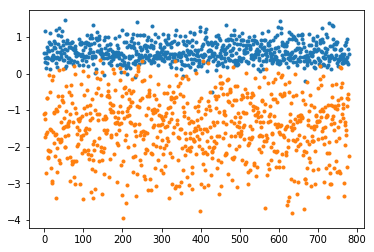

In [185]:
plt.plot(X[np.where(Y==1),1].T,'.')
plt.plot(X[np.where(Y==0),0].T,'.')

In [12]:
model = LogisticRegression()
rfe = RFE(model, 3)
fit = rfe.fit(X, Y)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

Num Features: 3
Selected Features: [ True  True False False False False  True False False False False False
 False]
Feature Ranking: [ 1  1  4  7  2  8  1 10  5  6  3 11  9]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

# Particular MFCC

In [17]:
#Choose these parameters. Calculates results for combinations of mfccs, from 0-9, taken n_mfcc at a time.
n_mfcc = 1
n_features = 2
component = createcombinations(n_mfcc)
t_window = 1
t_frame = 0.025
t_shift = 0.01
    
row_list = [["MFCCs", "Actual(0)Predicted(0)", "Actual(0)Predicted(1)", "Actual(1)Predicted(0)", "Actual(1)Predicted(1)","Accuracy","(0) f1", "(0) Precision", "(0) Recall","(1) f1", "(1) Precision", "(1) Recall", "Number of Entries (0)", "Number of Entries (1)",  ]]
#row_list = [["Actual(0)Predicted(0)"; "Actual(0)Predicted(1)"; "Actual(1)Predicted(0)"; "Actual(1)Predicted(1)";"Accuracy";"(0) f1"; "(0) Precision"; "(0) Recall";"(1) f1"; "(1) Precision"; "(1) Recall"; "Number of Entries (0)"; "Number of Entries (1)",  ]]

    
for components in component:
    print("For Components ", components)
    print("Loading Data....")
    training_data = []
    create_training_data(t_window, t_frame, t_shift, n_mfcc, components, training_data, n_features)
    
    print("PreProcessing Data....")
    random.shuffle(training_data) 
    X = []
    Y = []
    for features, label in training_data:
        X.append(features)
        Y.append(label)
        
    X = np.array(X).reshape(-1,n_mfcc*n_features)
    Y = np.array(Y)
    X = X/100
    
    print("Running Classifier....")
    for i in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1) 
        classifier = svm.SVC(kernel='linear')
        classifier.fit(X_train,y_train)
        y_pred = classifier.predict(X_test)
    
        cmatrix = confusion_matrix(y_test,y_pred, labels=[0,1])
        report = classification_report(y_test, y_pred, output_dict=True)
        df = pandas.DataFrame(report).transpose()
        creport = df.to_numpy()
    
        row_list.append([components, cmatrix[0,0], cmatrix[0,1], cmatrix[1,0], cmatrix[1,1], creport[2,1], creport[0,0], creport[0,1], creport[0,2], creport[1,0], creport[1,1], creport[1,2],  creport[0,3], creport[1,3]]) 
    print(" ")

#Writing your results into a file
with open('SVM' + str(n_mfcc) + '.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(row_list)

For Components  [0]
Loading Data....
PreProcessing Data....
Running Classifier....
 
For Components  [1]
Loading Data....
PreProcessing Data....
Running Classifier....
 
For Components  [2]
Loading Data....
PreProcessing Data....
Running Classifier....
 
For Components  [3]
Loading Data....
PreProcessing Data....
Running Classifier....
 
For Components  [4]
Loading Data....
PreProcessing Data....
Running Classifier....
 
For Components  [5]
Loading Data....


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Pre

PreProcessing Data....
Running Classifier....
 


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Pre